<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import re
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('../capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [7]:
class Flexlist(list):
    def __getitem__(self, keys):
        if isinstance(keys, (int, slice)): return list.__getitem__(self, keys)
        return [self[k] for k in keys]

In [17]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    sessions = []
    for ufile in sorted(glob(path_to_csv_files + '/*')):
        u = int(ufile.split('/')[-1].split(".")[0].split('user')[1])
        with open(ufile) as f:
            file_list = [line.strip() for line in list(f)[1:]]
        #print(ea for each_line in open(ufile)][1:])        
        for begin in range(0,len(file_list),window_size):            
            end = min(begin + session_length-1, len(file_list)-1)
            session = [site_freq[line.split(",")[-1]][0] for line in file_list[begin:end+1]]                
            d_begin = datetime.strptime(file_list[begin].split(",")[0], "%Y-%m-%d %H:%M:%S")
            d_end = datetime.strptime(file_list[end].split(",")[0], "%Y-%m-%d %H:%M:%S")
            
            # Time differences between two sequensional sides
            time_diff=np.zeros(session_length - 1, dtype=np.int_)
            time_prev_side = d_begin
            if end > begin:
                for line_ind, line in enumerate(file_list[begin + 1:end + 1]):
                    time_current_side = datetime.strptime(line.split(",")[0], "%Y-%m-%d %H:%M:%S")
                    time_diff[line_ind] = int((time_current_side - time_prev_side).total_seconds())
                    time_prev_side = time_current_side
                
            session_timespan = int((d_end - d_begin).total_seconds())
            n_unique_sites = len(set(session))
            start_hour = d_begin.hour
            day_of_week = d_begin.weekday()
            
            session.extend([0]*(session_length-len(session))
                         +  [session_timespan, n_unique_sites, start_hour, day_of_week, u])
            session.extend(time_diff)
            sessions.append(session)
            
    columns = ['site' + str(i+1) for i in range(session_length)]  \
              +  ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target'] \
              +  ['time_diff' + str(j) for j in range(1,session_length)]
    data = pd.DataFrame.from_records(sessions, columns=columns)
    
    
    return data  

    ''' ВАШ КОД ЗДЕСЬ '''

In [18]:
date_aby = datetime.strptime("2019-05-07 20:10:00", "%Y-%m-%d %H:%M:%S")
date_aby.weekday()

1

**Проверим функцию на игрушечном примере.**

In [19]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)


TypeError: list indices must be integers or slices, not str

In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
0,3,2,2,7,2,1,10,6,9,11,7998,8,9,4,1,287,1184,6278,186,2,1,2,3,55
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1,2,3,55,0,0,0,0,0,0
2,3,2,5,5,2,0,0,0,0,0,7935,3,9,4,2,287,1184,6278,186,0,0,0,0,0
3,4,1,2,1,2,1,1,6,8,4,7998,5,9,4,3,287,1184,6278,186,2,1,2,3,55
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3,287,1184,0,0,0,0,0,0,0


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

''' ВАШ КОД ЗДЕСЬ '''

CPU times: user 2.39 s, sys: 28 ms, total: 2.42 s
Wall time: 4.47 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
0,193,575,133,3,133,133,3,133,203,133,33,5,8,4,31,10,0,0,1,20,1,0,1,0
1,424,192,697,255,133,31,401,4703,221,55,284,10,8,4,31,1,0,163,105,0,1,3,3,8
2,55,3,55,55,5,295,424,337,915,55,258,7,8,4,31,0,14,1,242,0,0,1,0,0
3,476,4484,476,55,55,55,55,961,200,124,30,6,8,4,31,2,1,0,1,25,1,0,0,0
4,342,55,5,3759,260,211,4001,2238,696,2238,6,9,8,4,31,1,0,1,1,1,0,1,1,0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)
''' ВАШ КОД ЗДЕСЬ '''

CPU times: user 38.6 s, sys: 424 ms, total: 39.1 s
Wall time: 56.4 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [13]:
''' ВАШ КОД ЗДЕСЬ ''' 
print(new_features_10users['session_timespan'].median())

37.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [14]:
''' ВАШ КОД ЗДЕСЬ '''
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [15]:
''' ВАШ КОД ЗДЕСЬ '''
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [16]:
''' ВАШ КОД ЗДЕСЬ '''
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [17]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [18]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

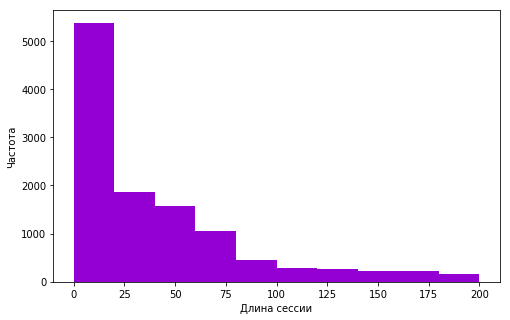

In [19]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Длина сессии")
plt.ylabel(u"Частота")
plt.hist(train_data_10users['session_timespan'], range = [0, 200], color="darkviolet")
plt.show()

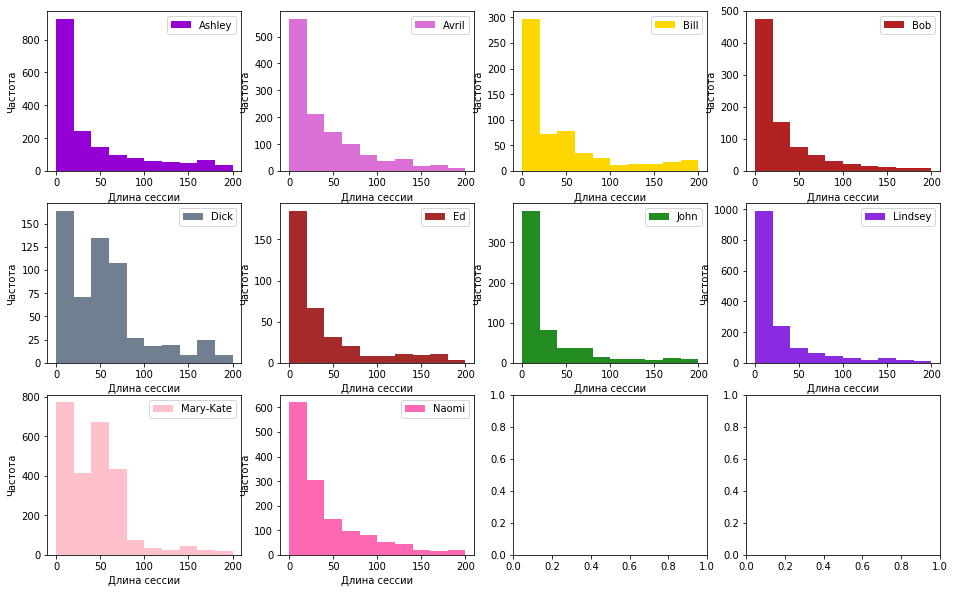

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
for (user, sub_df), ax in zip(pd.groupby(train_data_10users, 'target'), axes.flatten()):
    ax.hist(sub_df['session_timespan'], color=color_dic[user], range=[0, 200], bins=10)
    ax.set_xlabel(u"Длина сессии")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')
        
    ''' ВАШ КОД ЗДЕСЬ '''

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

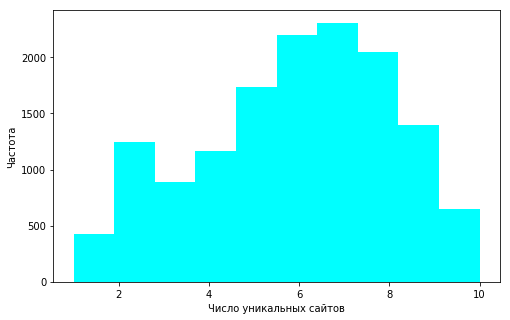

In [21]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Число уникальных сайтов")
plt.ylabel(u"Частота")
plt.hist(train_data_10users['#unique_sites'], color="aqua")
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

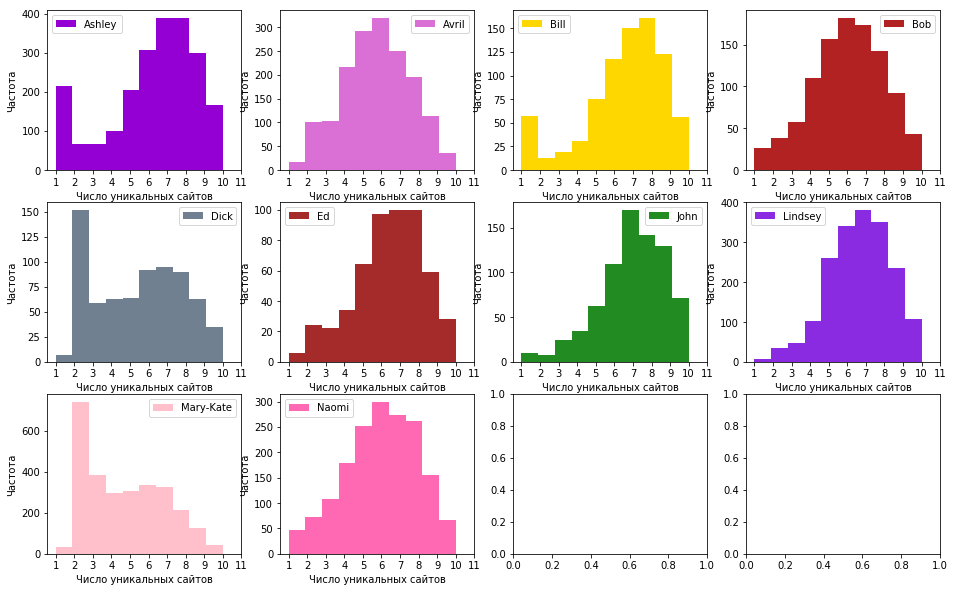

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
for (user, sub_df), ax in zip(pd.groupby(train_data_10users, 'target'), axes.flatten()):
    ax.hist(sub_df['#unique_sites'], color=color_dic[user], bins=10, align='mid')
    ax.set_xlabel(u"Число уникальных сайтов")
    ax.set_xticks(range(1, 12))
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')
        
        
    ''' ВАШ КОД ЗДЕСЬ '''

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

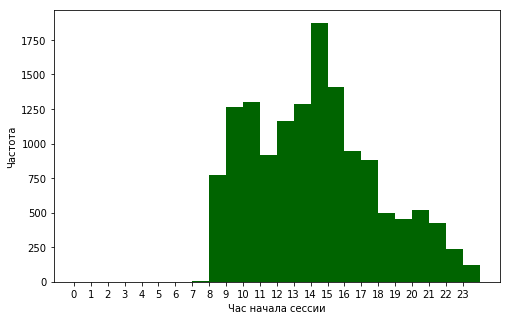

In [23]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
plt.xlabel(u"Час начала сессии")
plt.ylabel(u"Частота")
plt.hist(train_data_10users['start_hour'], color="darkgreen", bins=24, range=[0,24])
ax.set_xticks(range(24))
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

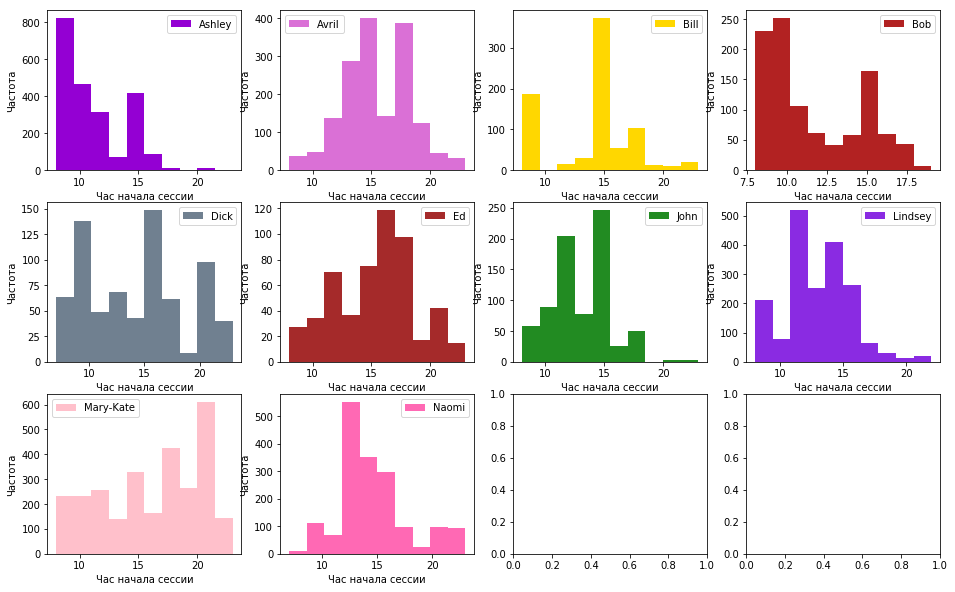

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(train_data_10users, 'target'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['start_hour'], color=color_dic[user])
    ax.set_xlabel(u"Час начала сессии")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

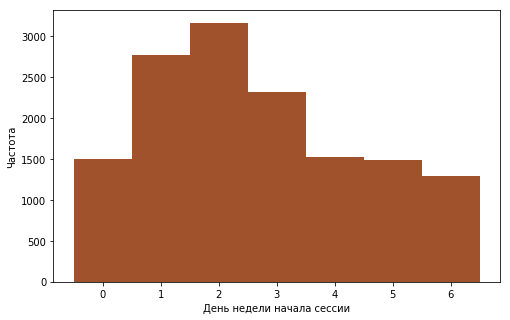

In [50]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"День недели начала сессии")
plt.ylabel(u"Частота")
plt.hist(train_data_10users['day_of_week'], color="sienna", bins=7, range=[0, 7], align="left")
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

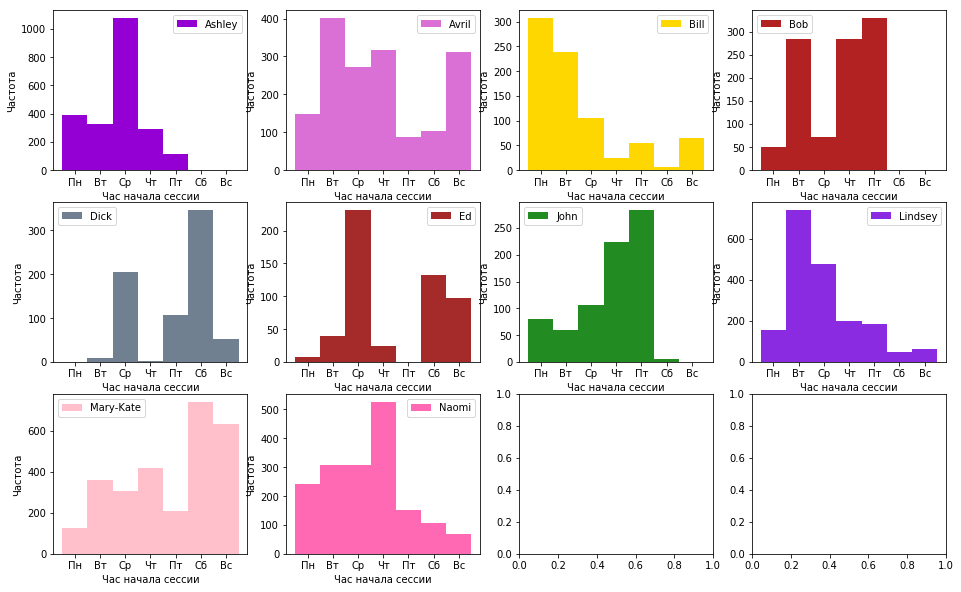

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(train_data_10users, 'target'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['day_of_week'], color=color_dic[user], bins=7, range=[0, 7], align="left")
    ax.set_xticks(range(7))
    ax.set_xlabel(u"Час начала сессии")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')
    ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1) Длина сессии:

 	У всех пользователей наблюдается максимум количества сессий длиной 0-20 секунд. 
	У большинства пользователей наблюдается резкое убывание количества сессий до длины сессии 100 сек, затем убывание не такое резкое, у некоторых пользователей дальше уровень кол-ва сессий примерно один и тот же или даже плавно увеличивается.
	Ashley: количество длин сессий на отрезке [20-40] сек примерно в 4 раза меньше, чем кол-во длин сессий на отрезке [0-20], дальше идет практически монотонное убывание кол-ва сессий. Заметен небольшой всплеск в районе 160-180 сек.
	Avril: убывание практически монотонное, с небольшим всплеском на отрезке [120, 140]. Количество длин сессий на отрезке [20 - 40] сек примерно в 3 раза меньше, чем на отрезке [0-20]
	Bill: количество длин сессий на отрезке [20-40] сек примерно в 5 раз меньше, чем на отрезке [0-20], на отрезке [40-60] сессий немного больше, чем на отрезке [20-40]. Начиная с длины сессии 100 сек наблюдается плавное монотонное незначительное увеличение кол-ва сессий до окончания интервала построения гистограммы (200 сек)
	Bob: наблюдается монотонное убывание количества сессий на всем интервале построения гистограммы, количество длин сессий на отрезке [20 - 40] сек примерно в 3 раза меньше, чем на отрезке [0-20]
	Dick: наблюдатся два ярко выраженных всплека на интервалах [40-60] и [60-80], когда кол-во сессий почти достигает уровня интервала [0-20], затем идет резкое падение (резче, чем у большинства пользователей) с небольшим всплеском на интервале [160-180]
	Ed: количество длин сессий на отрезке [20-40] сек примерно в 2.5 раза меньше, чем на отрезке [0-20], монотонное падение до длины сессии 80 сек, затем кол-во сессий держится примерно на одном уровне до длины сессии 180 сек, когда уровень резко падает.
	John: количество длин сессий на отрезке [20-40] сек примерно в 5 раз меньше, чем на отрезке [0-20], монотонное падение наблюдается до длины сессии 80 сек, затем до окончания гистограммы наблюдается уровень графика примерно один и тот же
	Lindsey: количество длин сессий на отрезке [20-40] сек примерно в 5 раз меньше, чем на отрезке [0-20], затем идет плавное падение уровня.
	Mary-Kate: падение уровня на отрезке [20-40] не такое существенное, как у других пользователей, менее 2х раз, затем наблюдается резкий всплеск почти до первоначального уровня, потом опять падение примерно до уровня отрезка [20-40], затем наблюдается падение в несколько раз (только у Dick при длине сессии 80 падение примерно такое же резко), и начиная со значения 100 уровень примерно один и тот же.
	Naomi: практически монотонное падение до окончания гистограммы, но падение при длине сессии 20 не такое резкое, как у большинства пользователей, примерно падение в 2 раза.

2) Число уникальных сайтов:

	У всех пользователей, кроме Dick и Mary-Kate, наблюдается максимум в районе 6-8 уникальных сайтов. При кол-ве уникальных сайтов, меньших точки масимума, частота возрастает практически монотонно для всех таких пользователей, кроме Bill и Ashley, а после точки максимума частота практически монотонно убывает. Пользователь Avril отличается тем, что у него график практически симметричен, у остальных рассмотренных пользователей цент тяжести смещен в право. У пользователей Bill и Ashley имеется локальный максимум в точке 1, а после этого локального максимума наблюдается падение и потом возрастание до максималного значения.
	У пользователей Dick и Mary-Kate максимум на гистограмме находится в точке 2. После этой точки идет падение: у Mary-Kate начиная с точки 3 и до точки 7 сохраняется примерно один и тот же уровень, затем идет падение; у Dick наблюдается один и тот же уровень на значениях 3-5, потом идет локальных всплеск, потом опять падение.

3) Час начала сессии:

	Форма графиков частоты часа начала сессии сильно отличается у пользователей. По графикам визуально легко отличить пользователей.
	У пользователя Bill два ярких часа активности: 8 и 14, в остальные часы кол-во сессий намного меньше.
	Только пользователи Ashley, Dick и Bob с утра иктивнее, чем в остальные часы, у Ashley и в меньшей степени Bob актиность в основном сосредоточена в утренние часы, с 8 по 10, у Dick активность более равномерно распределена до 22.00, с всплесками в 16 и 20 часов. 
	У Avril заметно быстрое возрастание числа сессий с 8 до 14 часов, а потом такое же резкое падение до 23 часов, с единственным локальным максимумом в 14 часов.
	У Ed также наблюдается возрастание числа сессий с 8 до 16 часов, а потом падение до 23 часов, в целом не такое резкое как у Avril, но с ярко выраженным всплеском в 16 часов.
	У John максимальная активность прихоится на 14 часов, при этом с 10 по 12 часов активность также на высоком уровне, а начиная с 18 часов до 23 активность минимальна, примерно в 10 раз меньше по сравнению с активностью в предыдущий час 16. 
	У Lindsey наибольшая активность приходится на дневные часы 12-14, в утренние часы 8-10 активноть заметно меньше, а начиная с 18 часов активность резко снижается.
	Mary-Kate единственный пользователь,у которого активность практически равномерно повышается с 8 утра до 20 вечера, затем число сессий резко сокращается в 22 часа.
	У Naomi наибольшая активность наблюдается в 12-14 часов, в утренние и вечерние часы 20-22 активность примерно одинаковая, но заметно меньше, чем днем.

4) Дни недели:

	По графикам частоты дня недели сессии также визуально легко отличить пользователей.
	Ashley активен только в рабочие дни, приче пик приходится на среду, а наименьшая активность среди рабочих дней у него в пятницу.
	У Avril три пика активности - вторник, четверг, воскресенье, высокий уровень активности также в среду.
	У Bill актиность снижается с понедельника по четверг, затем немного повышается в пятницу и примерно таккая де активность в воскресенье. В субботу почти нет сессий.
	Bob не пользуется интернетом по выходным, основная активность во вторник, четверг и пятницу, в остальные рабочие дни активность существенно меньше.
	Dick наиболее активен в субботу, в меньшей степени активен в среду.
    Ed наиболее активен в среду, но также довольно активен в выходные дни.
    John практически не активен в выходные дни, а в будни активность возрастает к концу недели.
    У Linsey, наоборот, активность падает со вторника по пятницу, в выходные активность существенно меньше.
    Mary-Kate наиболее активна на выходных, довольно активна в середине рабочей недели со вторника по четверг, в остальные дни менее активна.
    Naomi наиболее активна с понедельника по четверг с явным пиком в четверг, начиная с пятницы активность существенно меньше и монотонно убывает к воскресенью.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [52]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),'rb') as f:
    ''' ВАШ КОД ЗДЕСЬ '''
    site_freq_10 = pickle.load(f)
site_freq_10_list = sorted(site_freq_10.items(), key=lambda t: t[1][1], reverse=True)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [53]:
''' ВАШ КОД ЗДЕСЬ '''
top10_freqs = map(lambda t: t[1][1], site_freq_10_list[:10])
''' ВАШ КОД ЗДЕСЬ '''
top10_sites = map(lambda t: t[0], site_freq_10_list[:10])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

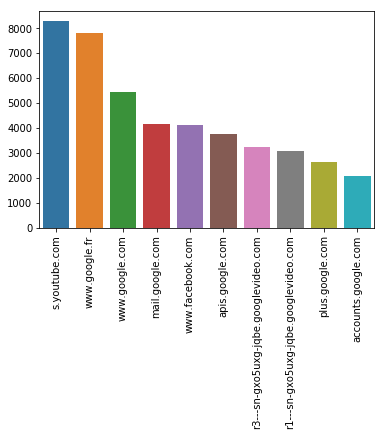

In [54]:
''' ВАШ КОД ЗДЕСЬ '''
plt.xticks(rotation='vertical')
sns.barplot(x=top10_sites, y=top10_freqs)
#x_ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [55]:
POPULAR_SOCIAL_NETWORKS = ["facebook",
                           "whatsapp",
                           "wechat",
                           "tumblr",
                           "qzone",
                           "instagram",
                           "weibo", 
                           "twitter",
                           "reddit",
                           "skype",
                           "viber",
                           "telegram",
                           "vk",
                           "vkontakte"]

def getSocialNetworkSites(site_freq, social_networks_list):
    social_networks_re = "({})".format("|".join(social_networks_list))
    regex=re.compile("\.{}\.".format(social_networks_re), re.IGNORECASE)

    social_network_sites = [site for site in site_freq.keys()
                            if regex.findall(site)]
    return social_network_sites

In [56]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),'rb') as f:
    ''' ВАШ КОД ЗДЕСЬ '''
    site_freq_150 = pickle.load(f)

In [57]:
print(getSocialNetworkSites(site_freq_10, POPULAR_SOCIAL_NETWORKS))

['dev.twitter.com', 'static.ak.facebook.com', 'api.facebook.com', 'api-read.facebook.com', 'fr.reddit.com', 'www.facebook.com', 'connect.facebook.net', 'fr-fr.facebook.com', 'developers.facebook.com', 'download.skype.com', 'apps.facebook.com', 'badge.facebook.com', 'login.skype.com', 'platform.twitter.com', 'fr.facebook.com', 'static-0.facebook.com', 'prod.registrar.skype.com', 'ar-ar.facebook.com', 'l.facebook.com', 'static.ak.connect.facebook.com', 'www.skype.com', 'graph.facebook.com', 'images.ak.instagram.com', 'api.skype.com', 's-static.ak.facebook.com', 'api.twitter.com', 'platform.tumblr.com', 'www.reddit.com', 'syndication.twitter.com']


In [58]:
print(getSocialNetworkSites(site_freq_150, POPULAR_SOCIAL_NETWORKS))

['badge.facebook.com', 'springbreakersfilm.tumblr.com', 'q95.queuev4.vk.com', '13.109.web1.im.weibo.com', 'cs417327.vk.com', 's.alitui.weibo.com', 'apps.twitter.com', 'im-a-rplayer.tumblr.com', 'fr.facebook.com', '11.109.web1.im.weibo.com', '3.56.web1.im.weibo.com', 'dev.twitter.com', 'rm.api.weibo.com', '10.94.web1.im.weibo.com', 'im56v4.vk.com', 'toutesunart.tumblr.com', 'service.weibo.com', 'www.tumblr.com', 'biz.weibo.com', 'rue89municipales2014.tumblr.com', 'the-lazygeek.tumblr.com', 'g.qzone.qq.com', 'account.weibo.com', '2.45.web1.im.weibo.com', 'mall.qzone.qq.com', 'lesjoiesducode.tumblr.com', 'ronanjoncour.tumblr.com', 'ufosfact.tumblr.com', 'static.weibo.com', 'qzs.qzone.qq.com', '1.56.web1.im.weibo.com', 'rsh.qzone.qq.com', 'passport.weibo.com', 'static.ak.facebook.com', '12.94.web1.im.weibo.com', 'open.qzone.qq.com', 'www.reddit.com', 'api.tumblr.com', 'syndication.twitter.com', 'www.weibo.com', 'assets.tumblr.com', 'it.reddit.com', 'badges.instagram.com', 'm.qzone.com', 'm

In [59]:
print([site_freq_10[site_id][0] for site_id in 
       getSocialNetworkSites(site_freq_10, POPULAR_SOCIAL_NETWORKS)])

[495, 18, 309, 2051, 3206, 5, 44, 566, 2021, 2029, 994, 571, 471, 22, 2096, 2547, 215, 1930, 4093, 1645, 2931, 275, 1424, 249, 17, 26, 2944, 380, 46]


In [60]:
# Новые признаки:
# 1) Месяц начала сессии;
# 2) Время суток начала сессии: [22.00 - 06.00) - night
#                 [06.00 - 10.00) - morning
#                 [10.00 - 18.00) - day
#                 [18.00 - 22.00) - evening
# 3) Доля суммарного времени пребывания пользователя на top-30 популярных сайтах в данной сессии
#    по отношению к длительности сессии
# 4) Количество посещений сайтов из top-30 в сессии
# 5) Доля времени посещения сайта социальных сетей относительно длительности сессии
# 6) Количество посещений социальных сетей в сессии
# 7) Среднее время пребывания пользователя на top-30 популярных сайтах в данной сессии
# 8) Среднее время посещения сайтов социальных сетей
def feature_engineering(path_to_csv_files, site_freq_path, features_names, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    '''
    window_size = session_length
    
    f = open(site_freq_path, 'rb')
    site_freq = pickle.load(f)
    f.close()
        
    social_network_sites = getSocialNetworkSites(site_freq,
                                                 POPULAR_SOCIAL_NETWORKS)
    social_network_sites_id = [site_freq[site][0] for site 
                               in social_network_sites]
        
    site_freq_list = sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)
    top_30_sites = map(lambda t: t[1][0], site_freq_list[:30])
    
    features_data = []
    for ufile in sorted(glob(path_to_csv_files + '/*')):
        user = int(ufile.split('/')[-1].split(".")[0].split('user')[1])
        
        f = open(ufile, 'rb')
        file_list = [line.strip() for line in list(f)[1:]]
        f.close()
        
        time_list = [datetime.strptime(line.split(",")[0], "%Y-%m-%d %H:%M:%S")
                     for line in file_list]
        time_diff_user = [int((time_list[i] - time_list[i-1]).total_seconds())
                          for i in range(1, len(file_list))]

        sites_user = [site_freq[line.split(",")[-1]][0] for line in file_list]
                  
        for begin in range(0,len(file_list), window_size):            
            end = min(begin + session_length-1, len(file_list)-1)
            session = sites_user[begin:end+1]
                        
            num_top30 = len([1 for site in session 
                             if site in top_30_sites])
            num_social_network = len([1 for site in session 
                             if site in social_network_sites_id])
            
            d_begin = time_list[begin]
            d_end = time_list[end]
                            
            session_timespan = int((d_end - d_begin).total_seconds())
            n_unique_sites = len(set(session))
            start_hour = d_begin.hour
            start_month = d_begin.month
            day_of_week = d_begin.weekday()
            
            # Time differences between two sequensional sides
            time_diff_session = time_diff_user[begin:end]
            
            time_top30 = [time_top30 for time_top30, site 
                          in zip(time_diff_session, session)
                          if site in top_30_sites and time_top30 > 0]
            
            time_mean_top30 = np.mean(time_top30) if time_top30 else 0 
            
            time_part_top30 = sum(time_top30) / session_timespan if session_timespan else 0
        
            time_social_net_sites = [time_site for time_site, site 
                                     in zip(time_diff_session, session)
                                     if site in social_network_sites_id
                                     and time_site > 0]
            
            time_part_social_net = sum(time_social_net_sites) / session_timespan if session_timespan else 0
            
            time_mean_social_net = np.mean(time_social_net_sites) if time_social_net_sites else 0
        
            if start_hour < 6 or start_hour >= 22:
                day_part = "night"
            elif start_hour < 10:
                day_part = "morning"
            elif start_hour < 18:
                day_part = "day"
            else:
                day_part = "evening"
                
            if len(session) < session_length:
                time_diff_session.extend([0] * (session_length - 1 - len(time_diff_session)))
                session.extend([0] * (session_length - len(session)))
                
            features_data_session = session + [session_timespan, n_unique_sites, start_hour, day_of_week] \
                                    + time_diff_session \
                                    + [start_month, day_part, time_part_top30,
                                       num_top30, time_part_social_net, num_social_network,
                                       time_mean_top30, time_mean_social_net, user]
            
            features_data.append(features_data_session)
            
    columns = ['site' + str(i+1) for i in range(session_length)]  \
              + ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week'] \
              + ['time_diff' + str(j) for j in range(1, session_length)] \
              + ['start_month', 'day_part', 'time_part_top30', 'num_top30', 'time_part_social_net',
                 'num_social_net', 'time_mean_top30', 'time_mean_social_net', 'target']
    
    data = pd.DataFrame.from_records(features_data, columns=columns)[features_names]
    
    return data

In [61]:
''' ВАШ КОД ЗДЕСЬ '''
session_length=10

features_names = ['site' + str(i+1) for i in range(session_length)]  \
              + ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week'] \
              + ['time_diff' + str(j) for j in range(1, session_length)] \
              + ['start_month', 'day_part', 'time_part_top30', 'num_top30',
                 'time_part_social_net', 'num_social_net', 'time_mean_top30', 'time_mean_social_net', 'target']
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           features_names=features_names,
                                           session_length=10)

new_features_10users['target_name'] = new_features_10users['target'].map(id_name_dict)

In [62]:
new_features_10users.head(5)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,start_month,day_part,time_part_top30,num_top30,time_part_social_net,num_social_net,time_mean_top30,time_mean_social_net,target,target_name
0,193,575,133,3,133,133,3,133,203,133,33,5,8,4,10,0,0,1,20,1,0,1,0,11,morning,0.030303,2,0.000000,0,1.0,0.0,31,John
1,424,192,697,255,133,31,401,4703,221,55,284,10,8,4,1,0,163,105,0,1,3,3,8,11,morning,0.000000,0,0.000000,0,0.0,0.0,31,John
2,55,3,55,55,5,295,424,337,915,55,258,7,8,4,0,14,1,242,0,0,1,0,0,11,morning,0.054264,2,0.000000,1,14.0,0.0,31,John
3,476,4484,476,55,55,55,55,961,200,124,30,6,8,4,2,1,0,1,25,1,0,0,0,11,morning,0.000000,0,0.000000,0,0.0,0.0,31,John
4,342,55,5,3759,260,211,4001,2238,696,2238,6,9,8,4,1,0,1,1,1,0,1,1,0,11,morning,0.166667,1,0.166667,1,1.0,1.0,31,John


In [65]:
%%time
session_length=10

features_names = ['site' + str(i+1) for i in range(session_length)]  \
              + ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week'] \
              + ['time_diff' + str(j) for j in range(1, session_length)] \
              + ['start_month', 'day_part', 'time_part_top30', 'num_top30', 'time_part_social_net', 
                 'num_social_net', 'time_mean_top30', 'time_mean_social_net', 'target']
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           features_names=features_names, session_length=10)

CPU times: user 33.1 s, sys: 80 ms, total: 33.2 s
Wall time: 33.2 s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

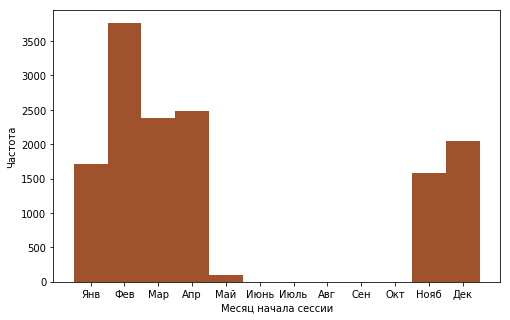

In [66]:
''' ВАШ КОД ЗДЕСЬ ''' 
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Месяц начала сессии")
plt.ylabel(u"Частота")
plt.hist(new_features_10users['start_month'], color="sienna", bins=12, range=[1, 13], align="left")
ax = fig.gca()
ax.set_xticks(range(1, 13))
ax.set_xticklabels([u'Янв', u'Фев', u'Мар', u'Апр', u'Май', u'Июнь', u'Июль', u'Авг', u'Сен', u'Окт', u'Нояб', u'Дек'])
plt.show()

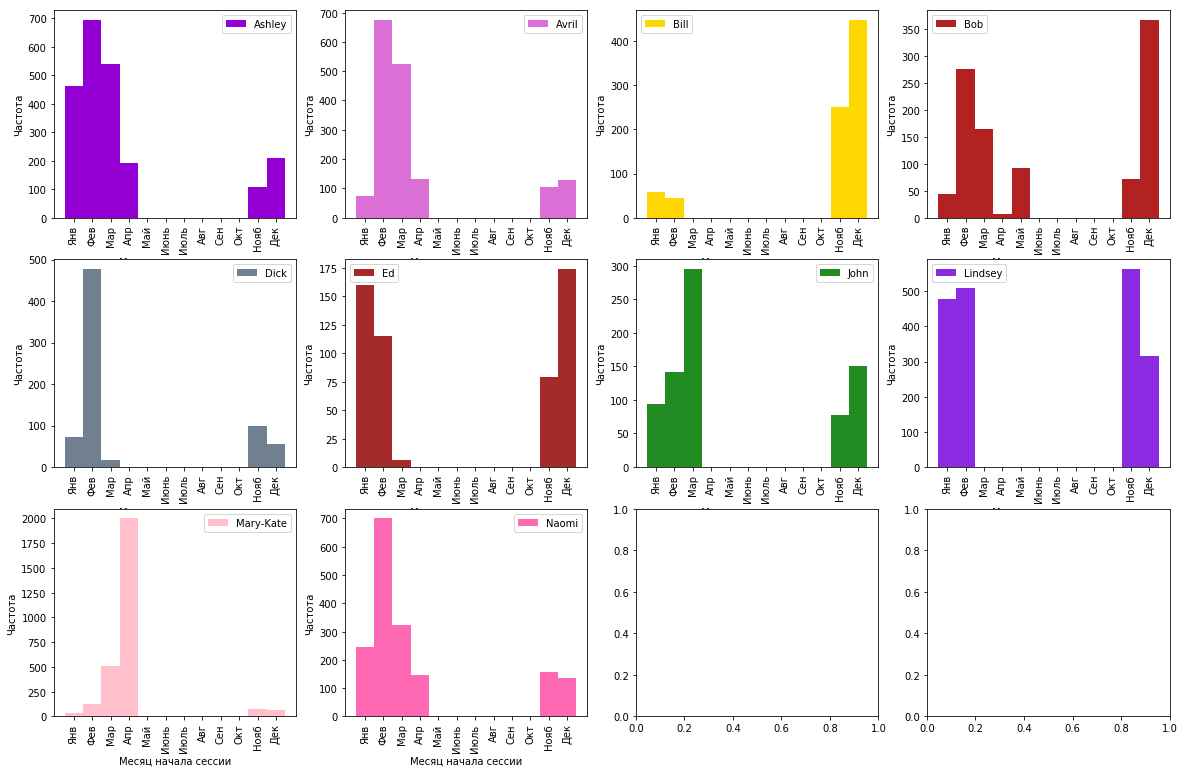

In [67]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 13))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['start_month'], color=color_dic[user], bins=12, range=[1, 13], align="left")
    ax.set_xticks(range(1, 13))
    ax.set_xlabel(u"Месяц начала сессии")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')
    ax.set_xticklabels([u'Янв', u'Фев', u'Мар', u'Апр', u'Май', u'Июнь', u'Июль', u'Авг', u'Сен', u'Окт', u'Нояб', u'Дек'])
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


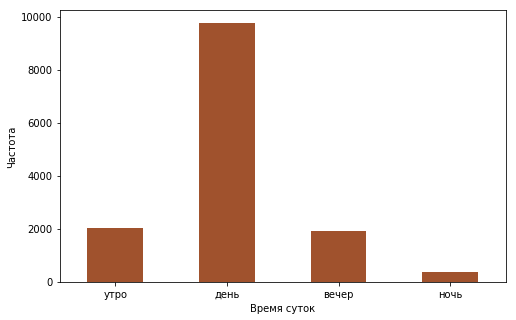

In [68]:
''' ВАШ КОД ЗДЕСЬ ''' 
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Время суток")
plt.ylabel(u"Частота")
ax = fig.gca()
new_features_10users['day_part'].value_counts()[['morning', 'day', 'evening', 'night']].plot(kind='bar', color='sienna', ax=ax)
ax.set_xticklabels([u'утро', u'день', u'вечер', u'ночь'])
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
plt.show()

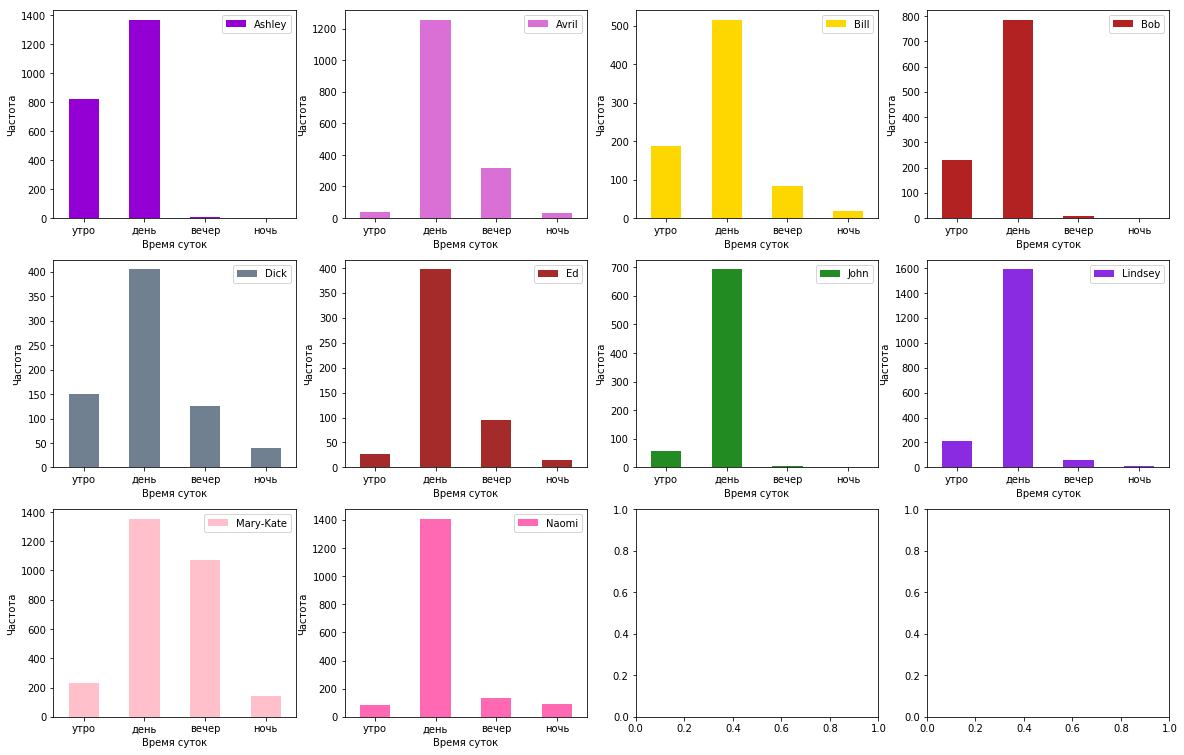

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 13))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    sub_df['day_part'].value_counts()[['morning', 'day', 'evening', 'night']].plot(kind='bar', color=color_dic[user], ax=ax)
    ax.set_xlabel(u"Время суток")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')
    ax.set_xticklabels([u'утро', u'день', u'вечер', u'ночь'])
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)


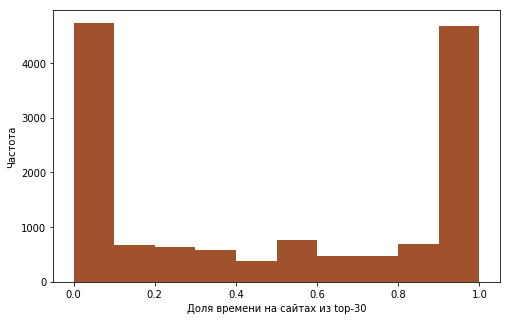

In [70]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Доля времени на сайтах из top-30")
plt.ylabel(u"Частота")
plt.hist(new_features_10users['time_part_top30'], color="sienna")
plt.show()

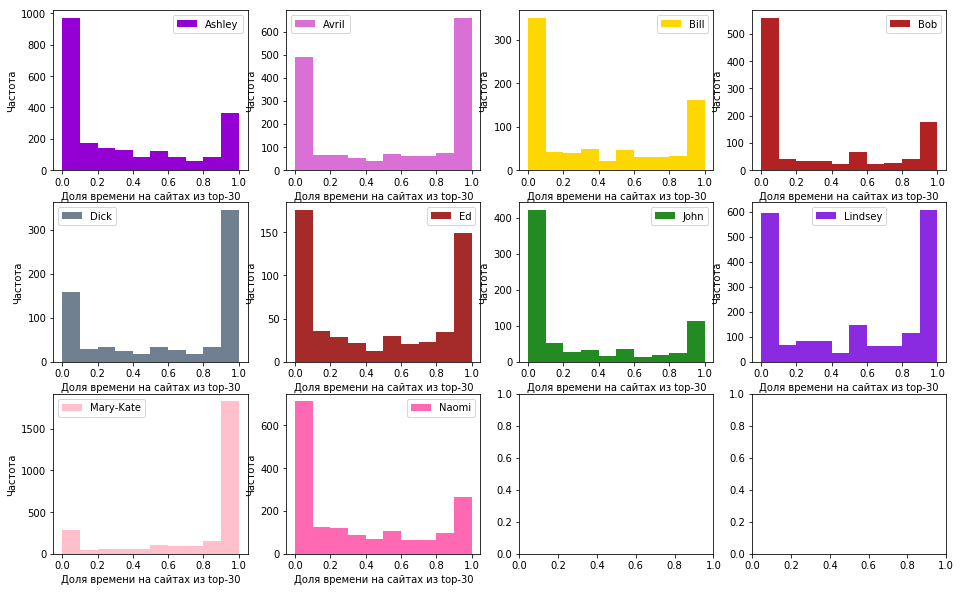

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['time_part_top30'], color=color_dic[user])
    ax.set_xlabel(u"Доля времени на сайтах из top-30")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')

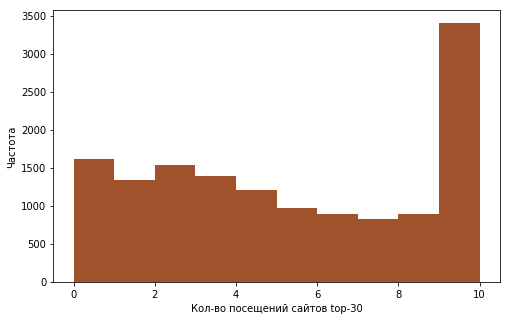

In [74]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Кол-во посещений сайтов top-30")
plt.ylabel(u"Частота")
plt.hist(new_features_10users['num_top30'], color="sienna")
plt.show()

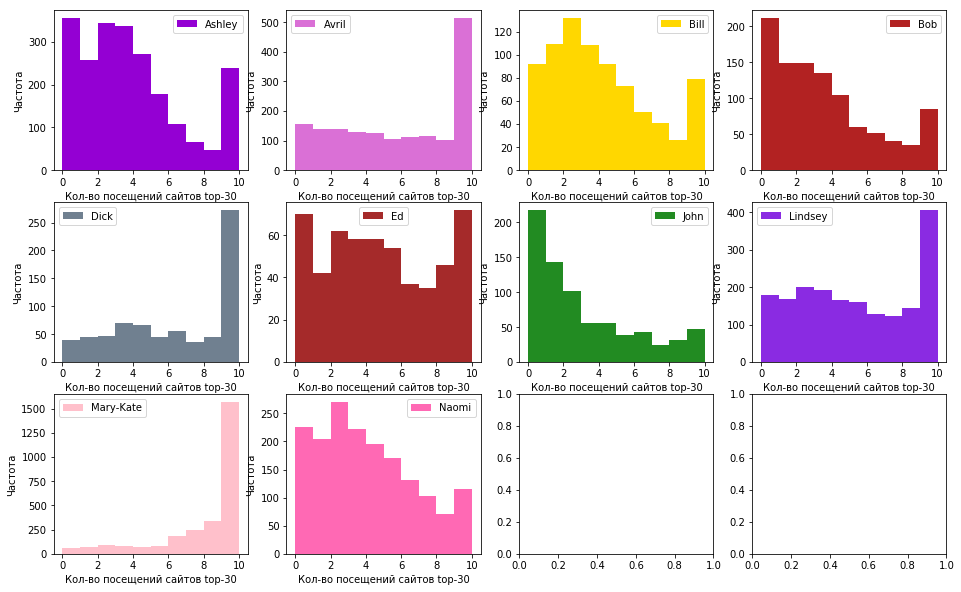

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['num_top30'], color=color_dic[user])
    ax.set_xlabel(u"Кол-во посещений сайтов top-30")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')

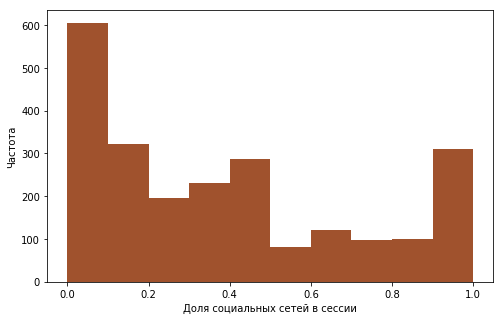

In [76]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Доля социальных сетей в сессии")
plt.ylabel(u"Частота")
plt.hist(new_features_10users['time_part_social_net'][new_features_10users['time_part_social_net'] > 0], color="sienna")
plt.show()

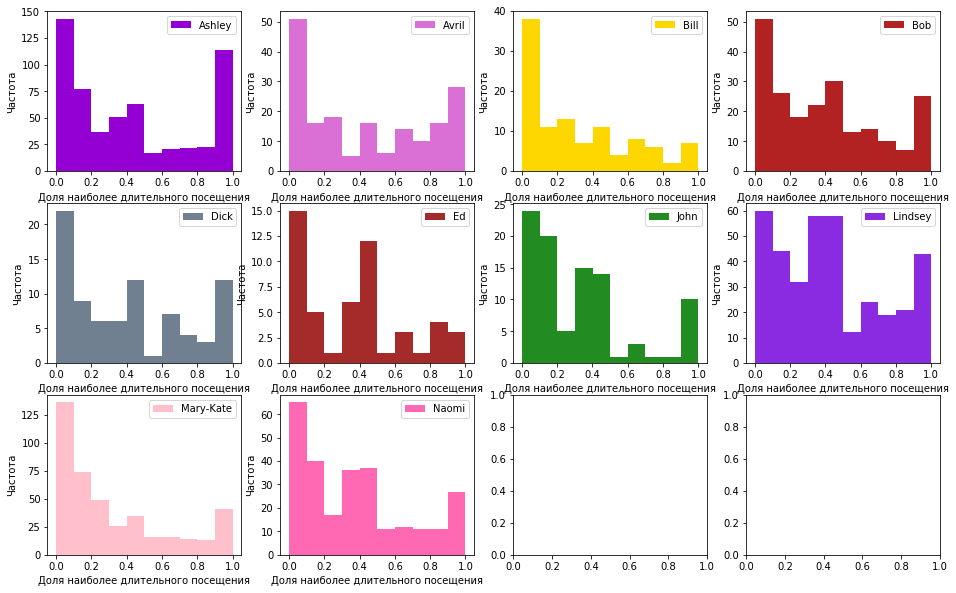

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['time_part_social_net'][sub_df['time_part_social_net'] > 0], color=color_dic[user])
    ax.set_xlabel(u"Доля наиболее длительного посещения")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')

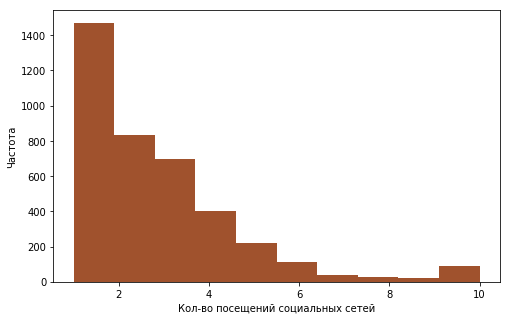

In [78]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Кол-во посещений социальных сетей")
plt.ylabel(u"Частота")
plt.hist(new_features_10users['num_social_net'][new_features_10users['num_social_net'] > 0], color="sienna")
plt.show()

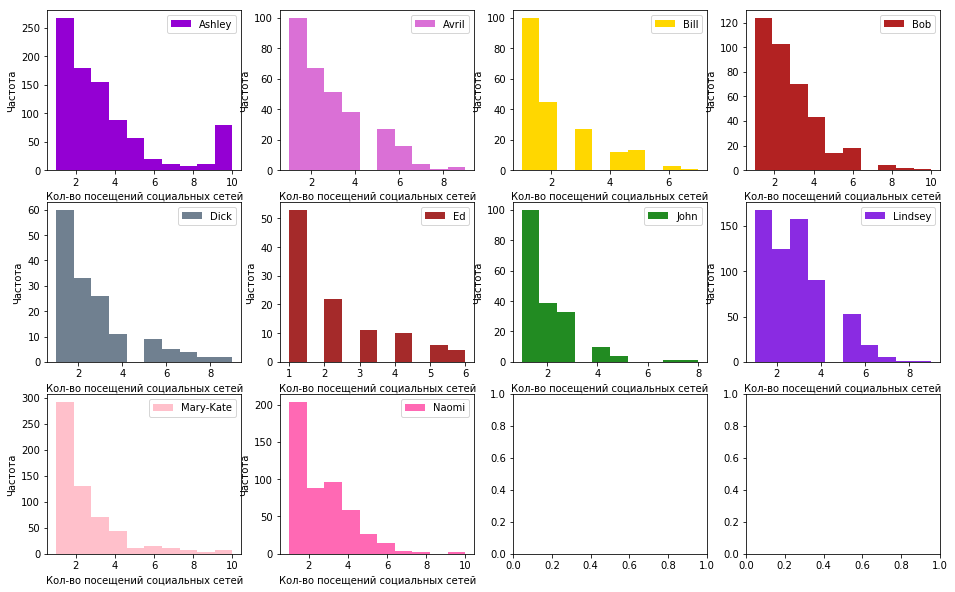

In [88]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['num_social_net'][sub_df['num_social_net'] > 0], color=color_dic[user])
    ax.set_xlabel(u"Кол-во посещений социальных сетей")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')

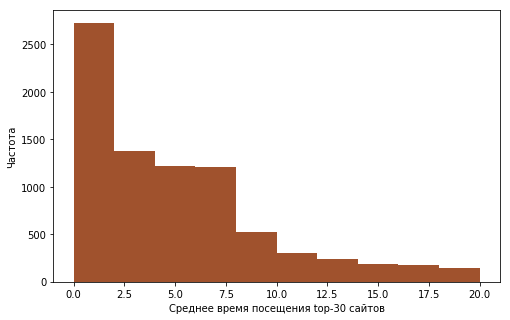

In [89]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Среднее время посещения top-30 сайтов")
plt.ylabel(u"Частота")
plt.hist(new_features_10users['time_mean_top30'][new_features_10users['time_mean_top30'] > 0], color="sienna", range=[0, 20])
plt.show()

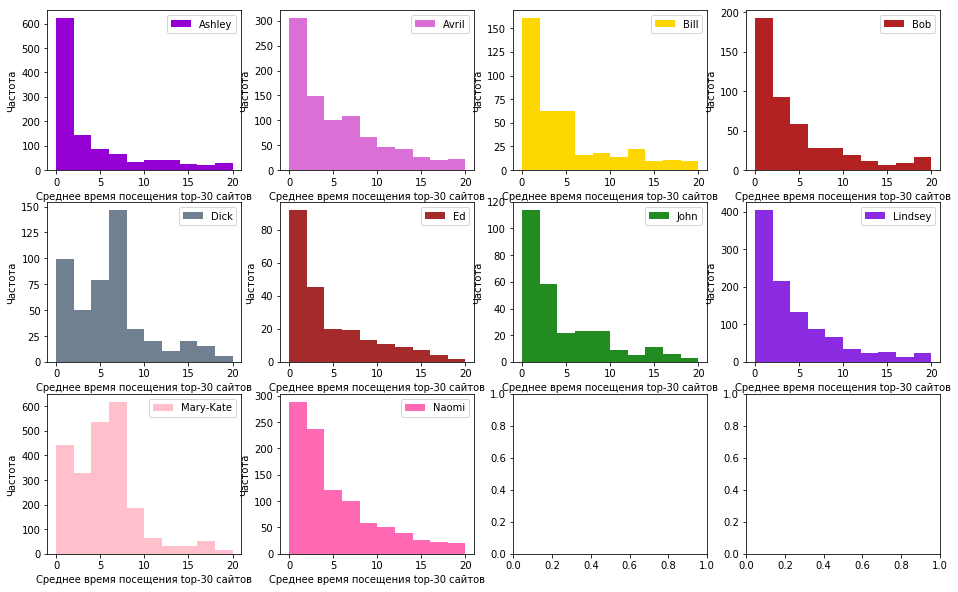

In [90]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['time_mean_top30'][sub_df['time_mean_top30'] > 0], color=color_dic[user], range=[0, 20])
    ax.set_xlabel(u"Среднее время посещения top-30 сайтов")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')

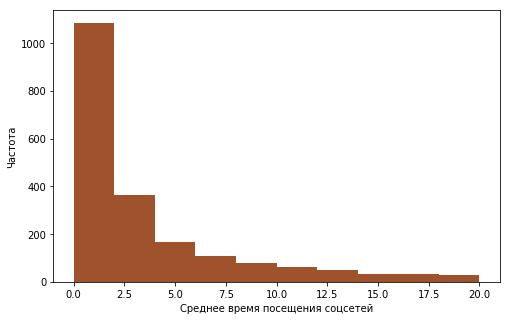

In [91]:
''' ВАШ КОД ЗДЕСЬ '''
fig = plt.figure(figsize=(8, 5))
plt.xlabel(u"Среднее время посещения соцсетей")
plt.ylabel(u"Частота")
plt.hist(new_features_10users['time_mean_social_net'][new_features_10users['time_mean_social_net'] > 0], color="sienna", range=[0, 20])
plt.show()

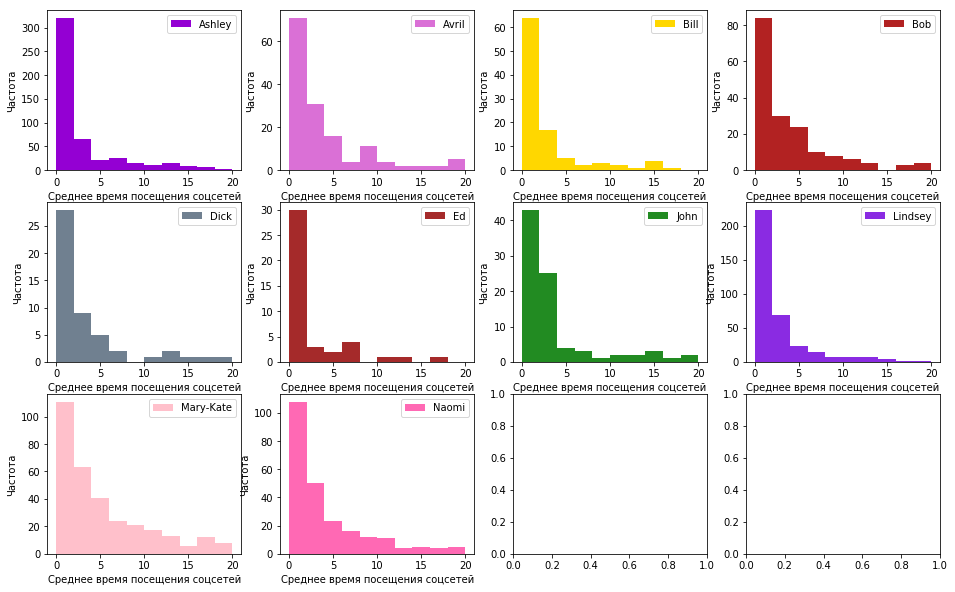

In [92]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for (user, sub_df), ax in zip(pd.groupby(new_features_10users, 'target_name'), axes.flatten()):
    ''' ВАШ КОД ЗДЕСЬ '''
    ax.hist(sub_df['time_mean_social_net'][sub_df['time_mean_social_net'] > 0], color=color_dic[user], range=[0, 20])
    ax.set_xlabel(u"Среднее время посещения соцсетей")
    ax.set_ylabel(u"Частота")
    ax.legend([user], loc='best')

In [94]:
select_features_names = ['site' + str(i+1) for i in range(session_length)]  \
                      + ['session_timespan', 'start_hour', 'day_of_week', '#unique_sites'] \
                      + ['time_diff' + str(j) for j in range(1, session_length)] \
                      + ['start_month', 'day_part', 'num_top30', 'time_mean_top30', 'num_social_net']
''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_10users = new_features_10users[select_features_names]
selected_features_150users = new_features_150users[select_features_names]

In [95]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 